In [1]:
%%cmd

pip install -U --user hmmlearn

Microsoft Windows [�汾 10.0.22631.4460]
(c) Microsoft Corporation����������Ȩ����

(base) d:\Documents\��ؾ���\WebSecMLLearnNote\Code>
(base) d:\Documents\��ؾ���\WebSecMLLearnNote\Code>pip install -U --user hmmlearn
     ------------------------------------ 124.1/124.1 kB 519.7 kB/s eta 0:00:00

(base) d:\Documents\��ؾ���\WebSecMLLearnNote\Code>

# 12.2 hello world！隐式马尔可夫

## 1.导入相关库

In [4]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt

from hmmlearn import hmm

Automatically created module for IPython interactive environment


## 2.训练模型

- **初始状态概率 (`startprob`)**:
  这个数组表示模型开始时处于各个隐藏状态的概率。例如，模型有4个隐藏状态，分别记为状态0、状态1、状态2和状态3。`startprob` 表示模型从状态0开始的概率为0.6，从状态1开始的概率为0.3，从状态2开始的概率为0.1，从状态3开始的概率为0.0。

- **状态转移矩阵 (`transmat`)**:
  这个矩阵表示从一个隐藏状态转移到另一个隐藏状态的概率。例如，`transmat[0][1]` 表示从状态0转移到状态1的概率为0.2。注意，状态1和状态3之间没有直接的转移路径，因此 `transmat[1][2]` 和 `transmat[2][1]` 均为0。

In [ ]:
startprob = np.array([0.6, 0.3, 0.1, 0.0])
# The transition matrix, note that there are no transitions possible
# between component 1 and 3
transmat = np.array([[0.7, 0.2, 0.0, 0.1],
                     [0.3, 0.5, 0.2, 0.0],
                     [0.0, 0.3, 0.5, 0.2],
                     [0.2, 0.0, 0.2, 0.6]])


- **每个状态的均值 (`means`)**:
  这个数组表示每个隐藏状态对应的观测值的均值。每个状态对应一个二维的均值向量。例如，状态0的均值为 `[0.0, 0.0]`，状态1的均值为 `[0.0, 11.0]`。


In [ ]:
# The means of each component
means = np.array([[0.0,  0.0],
                  [0.0, 11.0],
                  [9.0, 10.0],
                  [11.0, -1.0]])


- **每个状态的协方差矩阵 (`covars`)**:
  这个数组表示每个隐藏状态对应的观测值的协方差矩阵。`np.identity(2)` 生成一个2x2的单位矩阵，`np.tile` 将这个单位矩阵复制4次，形成一个4x2x2的数组，然后乘以0.5。这样，每个状态的协方差矩阵都是相同的，且为0.5倍的单位矩阵。

In [ ]:
# The covariance of each component
covars = .5 * np.tile(np.identity(2), (4, 1, 1))


- **构建HMM模型并设置参数**:
  - `hmm.GaussianHMM(n_components=4, covariance_type="full")` 创建一个高斯HMM模型，其中 `n_components` 表示隐藏状态的数量，`covariance_type` 表示协方差矩阵的类型（这里使用全协方差矩阵）。
  - `model.startprob_`、`model.transmat_`、`model.means_` 和 `model.covars_` 分别设置模型的初始状态概率、状态转移矩阵、均值和协方差矩阵。

In [ ]:
# Build an HMM instance and set parameters
model = hmm.GaussianHMM(n_components=4, covariance_type="full")

# Instead of fitting it from the data, we directly set the estimated
# parameters, the means and covariance of the components
model.startprob_ = startprob
model.transmat_ = transmat
model.means_ = means
model.covars_ = covars

## 3.可视化

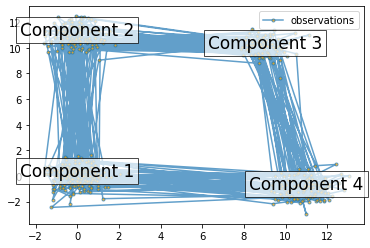

In [6]:
# Generate samples
X, Z = model.sample(500)

# Plot the sampled data
plt.plot(X[:, 0], X[:, 1], ".-", label="observations", ms=6,
         mfc="orange", alpha=0.7)

# Indicate the component numbers
for i, m in enumerate(means):
    plt.text(m[0], m[1], 'Component %i' % (i + 1),
             size=17, horizontalalignment='center',
             bbox=dict(alpha=.7, facecolor='w'))
plt.legend(loc='best')
plt.show()

# 12.3 示例：使用隐式马尔可夫算法识别XSS攻击（一）

## 1.参数建模

In [ ]:
#-*- coding:utf-8 –*-
from apriori import apriori
from apriori import generateRules
import re


#myDat = [ [ 1, 3, 4 ], [ 2, 3, 5 ], [ 1, 2, 3, 5 ], [ 2, 5 ] ]
myDat=[]
#L, suppData = apriori(myDat, 0.5)
#rules = generateRules(L, suppData, minConf=0.7)
#print 'rules:\n', rules
with open("xss-train.txt") as f:
    for line in f:
        #/discuz?q1=0&q3=0&q2=0%3Ciframe%20src=http://xxooxxoo.js%3E
        index=line.find("?")
        if index>0:
            line=line[index+1:len(line)]
            #print line
            tokens=re.split('\=|&|\?|\%3e|\%3c|\%3E|\%3C|\%20|\%22|<|>|\\n|\(|\)|\'|\"|;|:|,|\%28|\%29',line)
            #print "token:"
            #print tokens
            myDat.append(tokens)
    f.close()

L, suppData = apriori(myDat, 0.15)
rules = generateRules(L, suppData, minConf=0.6)
#print 'rules:\n', rules# -*- coding:utf-8 -*-

import sys
import urllib
import urlparse
import re
from hmmlearn import hmm
import numpy as np
from sklearn.externals import joblib
import HTMLParser
import nltk


#处理参数值的最小长度
MIN_LEN=6

#状态个数
N=10
#最大似然概率阈值
T=-200
#字母
#数字 1
#<>,:"'
#其他字符2
SEN=['<','>',',',':','\'','/',';','"','{','}','(',')']

def ischeck(str):
    if re.match(r'^(http)',str):
        return False
    for i, c in enumerate(str):
        if ord(c) > 127 or ord(c) < 31:
            return False
        if c in SEN:
            return True
        #排除中文干扰 只处理127以内的字符


    return False

def etl(str):
    vers=[]
    for i, c in enumerate(str):
        c=c.lower()
        if   ord(c) >= ord('a') and  ord(c) <= ord('z'):
            vers.append([ord(c)])
        elif ord(c) >= ord('0') and  ord(c) <= ord('9'):
            vers.append([1])
        elif c in SEN:
            vers.append([ord(c)])
        else:
            vers.append([2])

    #print vers
    return np.array(vers)

def do_str(line):
    words=nltk.word_tokenize(line)
    print  words

def main(filename):
    X = [[0]]
    X_lens = [1]
    with open(filename) as f:
        for line in f:
            line=line.strip('\n')
            #url解码
            line=urllib.unquote(line)
            #处理html转义字符
            h = HTMLParser.HTMLParser()
            line=h.unescape(line)
            if len(line) >= MIN_LEN:
                print "Learning xss query param:(%s)" % line
                do_str(line)

            #X=np.concatenate( [X,vers])
            #X_lens.append(len(vers))


    #print X
    #remodel = hmm.GaussianHMM(n_components=N, covariance_type="full", n_iter=100)
    #remodel.fit(X,X_lens)
    #joblib.dump(remodel, "xss-train.pkl")

    #return remodel

def test(remodel,filename):
    with open(filename) as f:
        for line in f:
            # 切割参数
            result = urlparse.urlparse(line)
            # url解码
            query = urllib.unquote(result.query)
            params = urlparse.parse_qsl(query, True)

            for k, v in params:

                if ischeck(v) and len(v) >=N :
                    vers = etl(v)
                    pro = remodel.score(vers)
                    #print  "CHK SCORE:(%d) QUREY_PARAM:(%s) XSS_URL:(%s) " % (pro, v, line)
                    if pro >= T:
                        print  "SCORE:(%d) QUREY_PARAM:(%s) XSS_URL:(%s) " % (pro,v,line)
                        #print line



if __name__ == '__main__':
    #remodel=main(sys.argv[1])
    #test(remodel,sys.argv[2])
    nltk.download()
    main(sys.argv[1])
